This is an example notebook to demonstrate the prediction of financial time-series data using the generalized Langevin equation (GLE) on the example of a loaded stock price trajectory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mempred import *

%matplotlib inline

ver()

/home/hendrykn123/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/hendrykn123/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


This is mempred version 3.0
Latest feature: integrate Mitterwallner method


### Loading the data (here with yahoo finance)

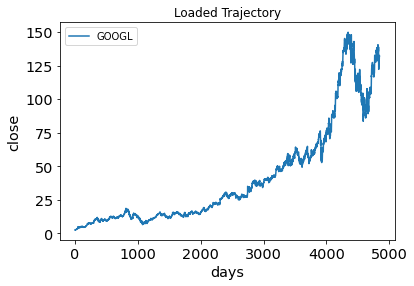

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2004-08-19 00:00:00-04:00,2.502503,2.604104,2.401401,2.511011,893181924,0.0,0.0
1,2004-08-20 00:00:00-04:00,2.527778,2.729730,2.515015,2.710460,456686856,0.0,0.0
2,2004-08-23 00:00:00-04:00,2.771522,2.839840,2.728979,2.737738,365122512,0.0,0.0
3,2004-08-24 00:00:00-04:00,2.783784,2.792793,2.591842,2.624374,304946748,0.0,0.0
4,2004-08-25 00:00:00-04:00,2.626627,2.702703,2.599600,2.652653,183772044,0.0,0.0


In [2]:
trj = loaddata_yahoo(symbol = 'GOOGL', interval = 'daily', start_date = '1990-01-01', verbose_plot = True)
#trj['Date'] = pd.to_datetime(trj['Date'])
trj.head()

### Extracting memory kernel from trajectory using the generalized Langevin equation (GLE)
First we check for trend

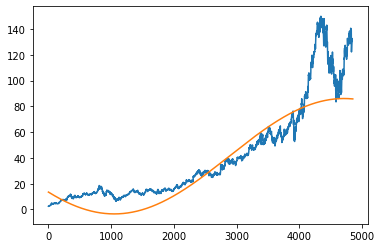

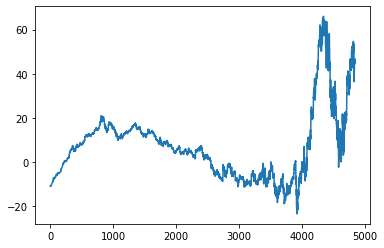

In [3]:
n_steps=10
cut=len(trj)
t= trj.index.values
x = trj['Close'].values

#param,x_noise, x_trend = extrapolate_fourier_analysis_trend(trj.index,trj['Close'],cut,n_steps=n_steps,find_peaks=False,mph=0.01,N=1,verbose=True,fit=True)
#x_noise=x_noise.values

detrend = True
fit_trend_part = False
N_trend=2
deseasonalize = False
N_seas=5
fit_seas_part = False

x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                               N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part,fac_high=1000)



plt.plot(trj["Close"])
plt.plot(x_trend)
plt.show()

t_noise = np.arange(len(x_noise))
plt.plot(t_noise,x_noise)
plt.show()



plotting extracted memory kernel...


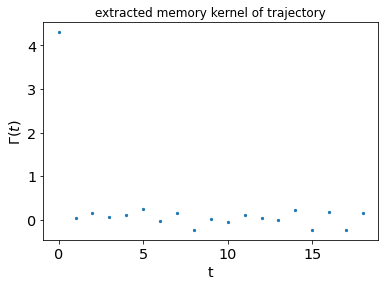

plotting running integral of kernel...


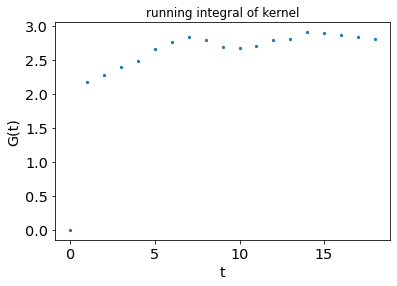

In [4]:
Mitterwallner = False

predict=GLEPrediction(bins=10,  cut = len(trj) ,trunc=20, dt = 1, no_fe=True, plot_pred = True)

if Mitterwallner:
    p0=[0.21,  1.82, 5.88,0.23, 9.276517012388659]
    bounds = [[-10,0,0,0,0],[10,10,10,10,100]]
    kernel = predict.extractKernel_estimator([trj["Close"].values], plot_kernel =True,p0=p0,bounds=bounds,end=20,verbose=True)
else:
    kernel = predict.extractKernel([trj["Close"].values], fit_kernel = False,plot_kernel=True)


### Running a GLE-prediction with colored noise generation
Running multiple predictions and calculating the average

plotting prediction...


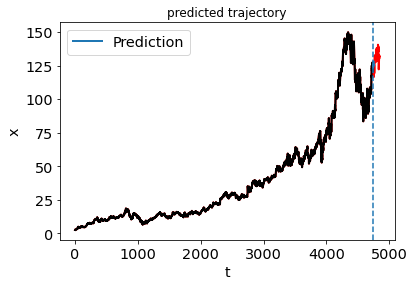

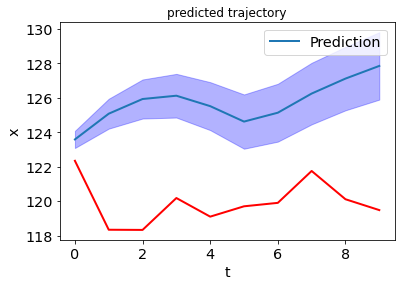

In [5]:
Mitterwallner = False

predict=GLEPrediction(bins=10,  cut = len(trj)-100 ,trunc=100, dt = 1, no_fe=True, plot_pred = True)

if Mitterwallner:
    p0=[0.21,  1.82, 5.88,0.23, 9.276517012388659]
    bounds = [[-10,0,0,0,0],[10,10,10,10,100]]
    kernel = predict.extractKernel_estimator([trj["Close"].values], plot_kernel =True,p0=p0,bounds=bounds,end=20,verbose=True)
else:
    kernel = predict.extractKernel([trj["Close"].values], fit_kernel = False)

predGLE=predict.predictGLE([trj["Close"].values], n_steps=n_steps, n_preds = 100, return_full_trjs=True, zero_noise = False,cond_noise = 1)

### Running a Prediction with memoryless Langevin (non-linear potential)

plotting prediction...


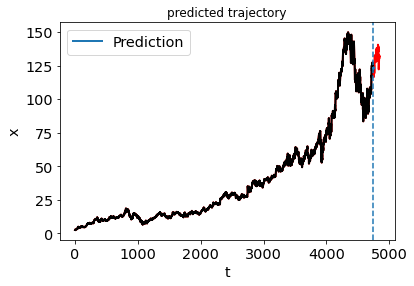

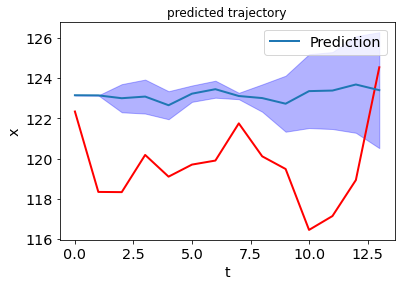

In [6]:
predict=GLEPrediction(bins=10,  cut = len(trj)-100 ,trunc=100, dt = 1, last_value_correction=True, no_fe=False, plot_pred = True)
predict.extractKernel([trj["Close"].values])
predGLE=predict.predictGLE([trj["Close"].values], n_steps=14, n_preds = 2, return_full_trjs=True, zero_noise = False, Langevin = True)

### GridSearch
find optimal values for hyper parameters in prediction (memory kernel length trunc, random force strength,...)
Attention: Only works for cut smaller than trajectory length

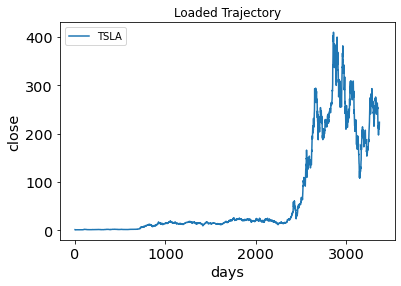

optimal alpha : 41
optimal trunc : 50
optimal conditional time : 10


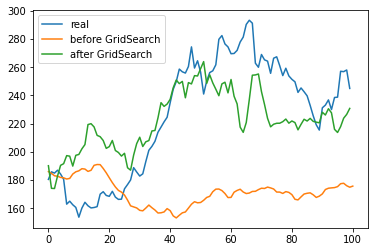

In [7]:
truncs = np.arange(50,200,25)
alphas = np.arange(1,400,20)
ts = [2,10]


trj = loaddata_yahoo(symbol = 'TSLA', interval = 'daily', start_date = '1990-01-01', verbose_plot = True)
cut = len(trj)-150
best_error, pred_GLE_best, best_trunc, best_alpha,best_th = mp.mp_grid_search(trj, value = 'Close', cut = cut, n_steps = 100, truncs = truncs, alphas = alphas,ts = ts)

mem = GLEPrediction(cut = cut, dt = 1, trunc = 100, plot_pred = False, no_fe = True)

kernel = mem.extractKernel([trj['Close'].values])
predGLE_default=mem.predictGLE([trj['Close'].values], n_steps = 100+1, n_preds = 10, return_full_trjs=True, zero_noise = False, alpha = 1,cond_noise=1)

plt.plot(trj['Close'][cut:cut+100].values, label = 'real')
plt.plot(predGLE_default[2], label = 'before GridSearch')
plt.plot(pred_GLE_best, label = 'after GridSearch')
plt.legend(loc = 'best')

## Extra Features:
### Plotting Performance (RMSLE) of prediction for different stocks, based on known data

predict TSLA...
> Compilation Time :  32.76637387275696
predict GOOGL...
> Compilation Time :  17.4272141456604
predict IBM...
> Compilation Time :  16.59233856201172
predict MSFT...
> Compilation Time :  47.40274214744568
predict NFLX...
> Compilation Time :  88.12418460845947


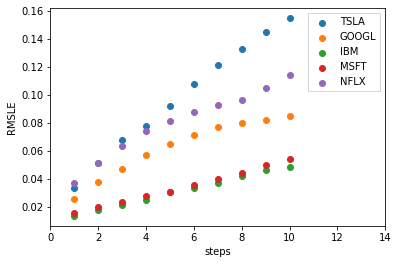

predict TSLA...
> Compilation Time :  32.797473669052124
predict GOOGL...
> Compilation Time :  17.220166444778442
predict IBM...
> Compilation Time :  16.648165941238403
predict MSFT...
> Compilation Time :  47.51521062850952
predict NFLX...
> Compilation Time :  87.87382245063782


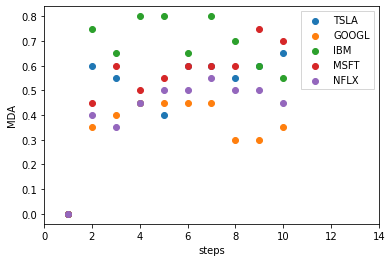

In [8]:
symbols = np.array(['TSLA', 'GOOGL', 'IBM', 'MSFT', 'NFLX'])

perform = performance_GLE(n_starts = 20, n_steps = 10)
rmsle = perform.get_scores(symbols, verbose_plot = True, metric = 'RMSLE')
mda= perform.get_scores(symbols, verbose_plot = True,metric = 'MDA')

### Calculate expected return for n_steps into future

In [9]:
changes = perform.predict_change(symbols, interval = 'daily', n_steps = 14, verbose_plot = False)

TSLA : 1.56 %
GOOGL : 3.19 %
IBM : -3.47 %
MSFT : -2.82 %
NFLX : 0.17 %


### Friction Barometer

In [10]:
data = trj['Close'].values
time = trj.index
index, gammas = friction_bar(data,time, extr_len = 200, trunc = 100, verbose_plot = False)

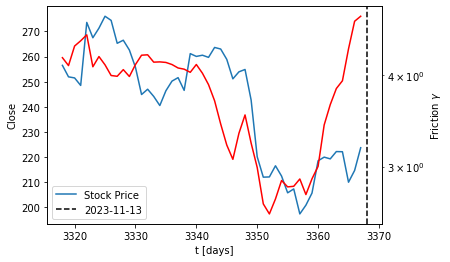

In [11]:
today = trj['Date'].dt.strftime('%Y-%m-%d')[len(trj)-1]
first = trj['Date'].dt.strftime('%Y-%m-%d')[0]

fig, ax1 = plt.subplots()

ax1.plot(index[-50:],trj['Close'].values[-50:], label = 'Stock Price')
ax1.set_xlabel('t [days]')
ax1.set_ylabel('Close')

#ax1.axvline(x=0, linestyle = '--', color = 'k', label =first)
ax1.axvline(x=len(trj), linestyle = '--', color = 'k', label =today)
ax1.legend(loc = 'best')

ax2 = ax1.twinx()

ax2.plot(index[-50:], gammas[-50:], color = 'red')
ax2.set_yscale("log")
ax2.set_xlabel('t [days]')
ax2.set_ylabel('Friction $\\gamma$')
#ax1.axvline(x=2415, linestyle = '--', color = 'k', label =today)
#plt.xlim(870,930)
plt.show()


### Running a prediction with GBM (linear drift) (not fixed)

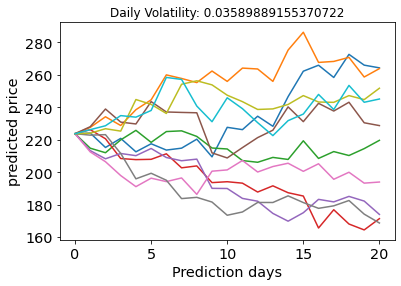

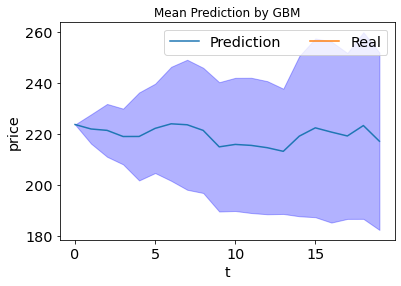

In [12]:
dt = 1
cut=len(trj)-1
n_steps=20
scen_size = 10

GBM = predictGBM(trj, value = 'Close', cut = cut, dt = 1, n_steps = n_steps, scen_size = scen_size, plot_pred = True)

